# Lab 4 — Bidding Predictions for Construction
**Course:** Machine Learning

**Authors:**
- Kimly John Vergara
- Daniel Mark Wiegand

**Instructor:**
Anfernee Joan Bajar Ng

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline



## 1. Load Dataset

Load all dataset splits from the provided CSV files:
- `raw_train.csv` — training data with pay-item rows and `total_bid` labels
- `raw_test.csv` — test data with the same features (no `total_bid`)
- `sample_submission.csv` — expected submission format


In [18]:
df         = pd.read_csv("bidding-predictions-for-construction/raw_train.csv")
df_test    = pd.read_csv("bidding-predictions-for-construction/raw_test.csv")
sample_sub = pd.read_csv("bidding-predictions-for-construction/sample_submission.csv")

print("Train shape:      ", df.shape)
print("Test shape:       ", df_test.shape)
print("Sample sub shape: ", sample_sub.shape)


Train shape:       (832056, 15)
Test shape:        (120305, 13)
Sample sub shape:  (1447, 2)


## 2. Exploratory Data Analysis (EDA)

Perform an initial exploration of the dataset to understand its structure, distribution, and quality before any modelling work.

### 2.1 Missing Values & Data Overview

Check for null values across all columns and inspect basic data types and non-null counts. This helps identify columns that may require imputation or removal.


In [19]:
df.isna().sum()

quantity                    0
amount                      0
job_category_description    0
bid_date                    0
total_bid                   0
num_pay_items               0
pay_item_description        0
unit_english_id             2
category_id                 0
category_description        0
job_id                      0
contractor_id               0
primary_location            0
pay_item_id                 0
row_id                      0
dtype: int64

### 2.2 Missing Values Imputation

`unit_english_id` has a small number of missing values. We impute them using the **training set mode** for both train and test to prevent any leakage from test data.


In [20]:
# Compute mode from training set only — reuse for test imputation
train_unit_mode = df["unit_english_id"].mode()[0]

df["unit_english_id"]      = df["unit_english_id"].fillna(train_unit_mode)
df_test["unit_english_id"] = df_test["unit_english_id"].fillna(train_unit_mode)

print("Remaining nulls (train):", df.isna().sum().sum())
print("Remaining nulls (test): ", df_test.isna().sum().sum())


Remaining nulls (train): 0
Remaining nulls (test):  0


### 2.3 Feature Distributions

Histograms for numerical features and value counts for key categorical columns.
Note: `amount` is only available in the training set and is excluded from modelling features.


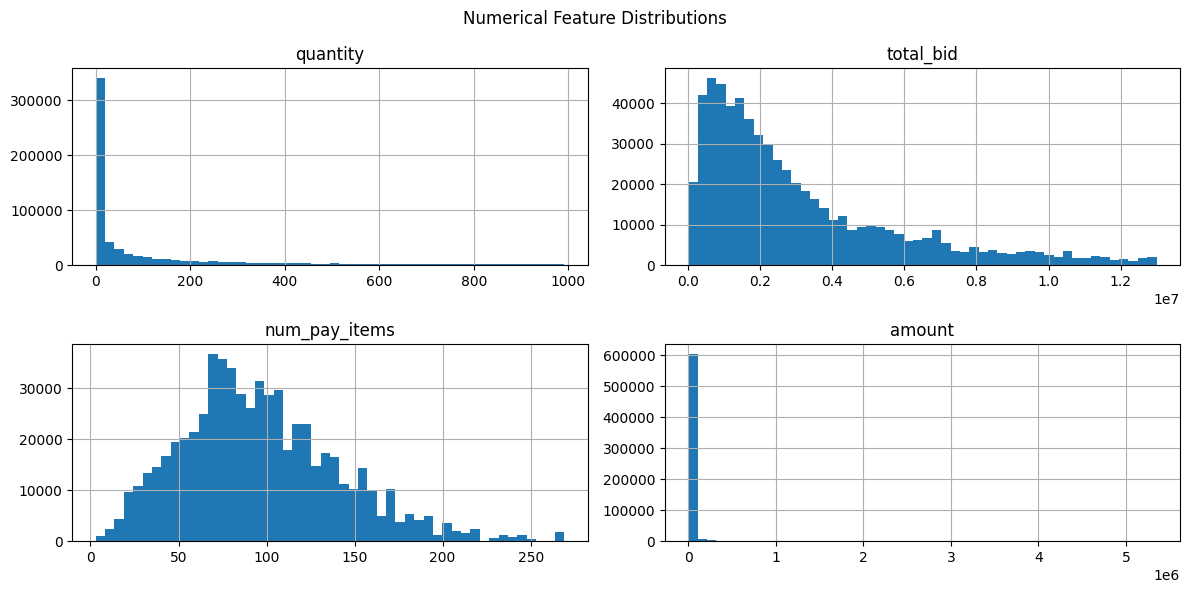


--- job_category_description ---
job_category_description
BRIDGE                   227494
ASPHALT                  194518
DRAINAGE-PIPE             31274
Uncategorized Project     27980
SIGNALIZATION             26954
CONCRETE-CULVERTS         21521
CONCRETE-MISC             17881
TRAFFIC CONTROL           15255
PAINTING STRUCTURES        9186
GRADING/EXCAVATION         8102
Name: count, dtype: int64

--- unit_english_id ---
unit_english_id
EACH     243308
L.F.     110588
$         70259
TON       46660
C.Y.      40674
S.Y.      29262
SYS       21690
L.S.      19324
S.F.      13455
MONTH      9500
Name: count, dtype: int64

--- category_description ---
category_description
TRAFFIC CONTROL                 75740
ALTERNATES/BONUS/TIME           67437
BRIDGE                          46907
ASPHALT                         40993
STRIPING/PAVEMENT MARKING       36964
CLEARING                        33109
MOBILIZATION                    32765
GUARD RAIL                      29915
DRAINAGE-INLE

In [ ]:
# Histograms for numerical features (train-only columns included for exploration)
numerical_cols = ["quantity", "total_bid", "num_pay_items", "amount"]
df[numerical_cols].hist(bins=50, figsize=(12, 6))
plt.suptitle("Numerical Feature Distributions")
plt.tight_layout()
plt.show()



Our data tells that most of the numerical data is left skewed. It is probably because most bids are at lower price. it makes sense because they compete for lower bids.

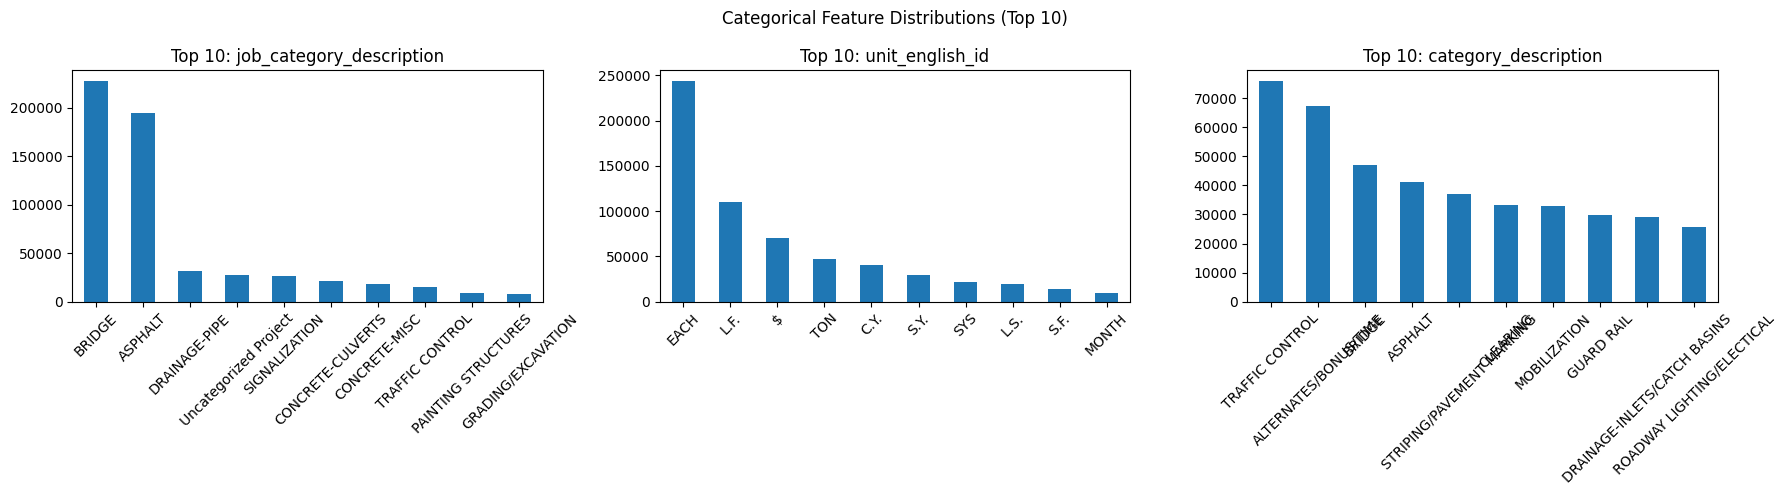

In [35]:
cat_cols_eda = ["job_category_description", "unit_english_id", "category_description"]

fig, axes = plt.subplots(1, len(cat_cols_eda), figsize=(18, 5))
for ax, col in zip(axes, cat_cols_eda):
    counts = df[col].value_counts().head(10)
    counts.plot(kind="bar", ax=ax)
    ax.set_title(f"Top 10: {col}")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)

plt.suptitle("Categorical Feature Distributions (Top 10)")
plt.tight_layout()
plt.show()


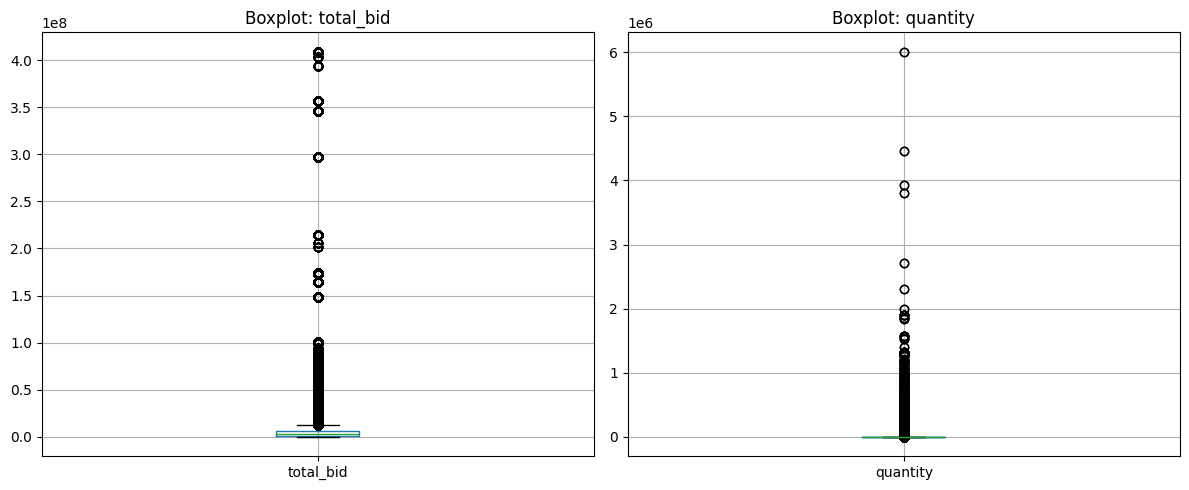

total_bid: 89968 outliers (10.8%)
quantity: 139707 outliers (16.8%)


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df.boxplot(column="total_bid", ax=axes[0])
axes[0].set_title("Boxplot: total_bid")

df.boxplot(column="quantity", ax=axes[1])
axes[1].set_title("Boxplot: quantity")

plt.tight_layout()
plt.show()

# IQR-based outlier counts
for col in ["total_bid", "quantity"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")



### 2.5 Outlier Removal

Remove rows where `total_bid` or `quantity` fall outside the IQR fence (Q1 − 1.5×IQR, Q3 + 1.5×IQR). The filter is computed on the **training set only** and applied only to `df`; test data is left unchanged.


In [23]:
before = len(df)

for col in ["total_bid", "quantity"]:
    Q1  = df[col].quantile(0.25)
    Q3  = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df  = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

df = df.reset_index(drop=True)
print(f"Rows removed: {before - len(df):,}  ({(before - len(df)) / before * 100:.1f}%)")
print(f"Remaining rows: {len(df):,}")


Rows removed: 213,552  (25.7%)
Remaining rows: 618,504


### 2.6 Patterns & Correlations

Investigate relationships between features and the target variable:
- Correlation matrix / heatmap for numerical features
- `total_bid` trends over time (`bid_date`)
- Differences in bidding behaviour across `job_category_description`


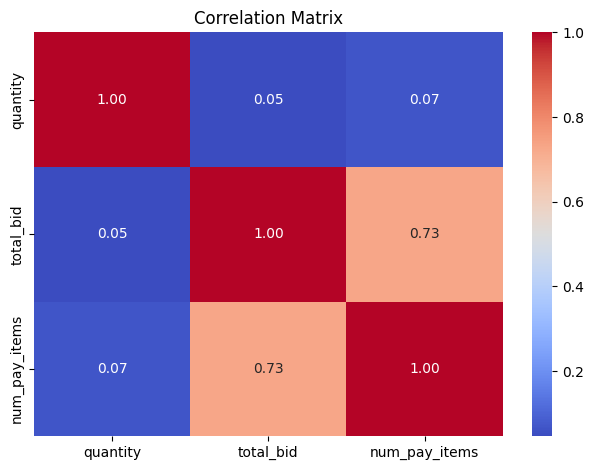

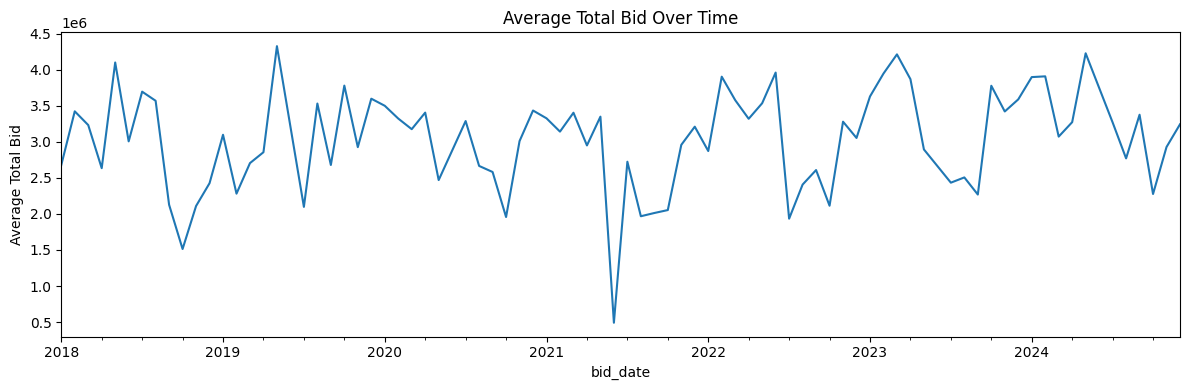

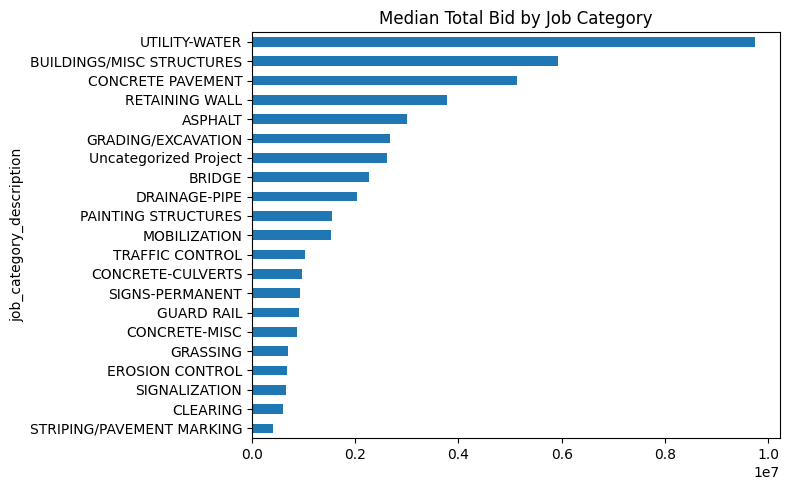

count    6.185040e+05
mean     3.063118e+06
std      2.743453e+06
min      1.286500e+04
25%      1.056151e+06
50%      2.141328e+06
75%      4.189375e+06
max      1.299339e+07
Name: total_bid, dtype: float64

In [24]:
# Correlation heatmap (features available in both train and test)
numerical_cols = ["quantity", "total_bid", "num_pay_items"]
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Total bid over time
df["bid_date"] = pd.to_datetime(df["bid_date"])
df.groupby(df["bid_date"].dt.to_period("M"))["total_bid"].mean().plot(
    figsize=(12, 4), title="Average Total Bid Over Time"
)
plt.ylabel("Average Total Bid")
plt.tight_layout()
plt.show()

# Total bid by job category
df.groupby("job_category_description")["total_bid"].median().sort_values().plot(
    kind="barh", figsize=(8, 5), title="Median Total Bid by Job Category"
)
plt.tight_layout()
plt.show()


df["total_bid"].describe()


## 3. Feature Engineering

Transform and enrich the raw features to improve model performance:
- Extract temporal features from `bid_date` (year, month, day-of-week as cyclical sine/cosine)
- Encode categorical variables using `OrdinalEncoder` with unknown-value handling
- Scale numerical features (`quantity`, `num_pay_items`) **after** the train/val split to prevent leakage


### 3.1 Temporal Features

Extract year and month from `bid_date`. Day-of-week is encoded as cyclical sine/cosine features so that Monday (0) and Sunday (6) are treated as adjacent rather than far apart numerically.


In [25]:
def add_temporal_features(frame: pd.DataFrame) -> pd.DataFrame:
    frame = frame.copy()
    frame["bid_date"] = pd.to_datetime(frame["bid_date"])
    frame["bid_year"]  = frame["bid_date"].dt.year
    frame["bid_month"] = frame["bid_date"].dt.month
    dow = frame["bid_date"].dt.dayofweek          # 0=Mon … 6=Sun
    frame["bid_dow_sin"] = np.sin(2 * np.pi * dow / 7)
    frame["bid_dow_cos"] = np.cos(2 * np.pi * dow / 7)
    return frame

df      = add_temporal_features(df)
df_test = add_temporal_features(df_test)


### 3.2 Categorical Encoding

Encode categorical columns using `OrdinalEncoder`. Unlike `LabelEncoder`, it handles unseen test categories gracefully by mapping them to `-1` via `handle_unknown="use_encoded_value"`. The encoder is **fit on training data only**.


In [26]:
cat_cols = [
    "job_category_description", "unit_english_id",
    "category_description", "primary_location"
]
enc_cols = [c + "_enc" for c in cat_cols]

ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df[enc_cols]      = ord_enc.fit_transform(df[cat_cols].astype(str))   # fit on train only
df_test[enc_cols] = ord_enc.transform(df_test[cat_cols].astype(str))  # transform test

df[enc_cols].head()


,job_category_description_enc,unit_english_id_enc,category_description_enc,primary_location_enc
0,1.0,6.0,18.0,90.0
1,1.0,6.0,18.0,27.0
2,1.0,6.0,18.0,27.0
3,1.0,0.0,0.0,90.0
4,1.0,0.0,0.0,27.0


## 4. Train / Validation Split & Scaling

Split the processed training data 80/20. `StandardScaler` is **fit on `X_train` only** and then applied to `X_val` and `X_test`, preventing any validation or test statistics from leaking into the scaling step.


In [27]:
feature_cols = [
    "quantity", "num_pay_items",
    "bid_year", "bid_month",
    "job_category_description_enc", "unit_english_id_enc",
    "category_description_enc", "primary_location_enc",
]
target_col = "total_bid"
num_cols   = ["quantity", "num_pay_items"]

X = df[feature_cols].copy()
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit scaler on X_train only
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])

X_test = df_test[feature_cols].copy()
X_test[num_cols]  = scaler.transform(X_test[num_cols])

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Train size: 494803, Validation size: 123701, Test size: 120305


## 5. Modeling


### 5.2 Model Selection and Hyperparameter Tuning 

Use `RandomizedSearchCV` with `scoring="neg_mean_absolute_error"` to tune `HistGradientBoostingRegressor`. `n_iter=30` gives broader coverage of the search space compared to the default 10.


In [ ]:


pipeline = Pipeline([("model", HistGradientBoostingRegressor())])

param_distributions = [
    {
        "model":                    [HistGradientBoostingRegressor(random_state=42)],
        "model__max_iter":          [100, 200, 300],
        "model__learning_rate":     [0.01, 0.05, 0.1, 0.2],
        "model__max_depth":         [3, 5, 7, None],
        "model__l2_regularization": [0.0, 0.1, 1.0],
        "model__max_leaf_nodes":    [15, 31, 63],
        "model__min_samples_leaf":  [20, 50, 100],
    },
    {
        "model":                    [RandomForestRegressor(random_state=42)],
        "model__n_estimators":      [100, 200],
        "model__max_depth":         [3, 5, 7, None],
        "model__min_samples_leaf":  [20, 50, 100],
    },
    {
        "model":        [Ridge()],
        "model__alpha": [0.1, 1.0, 10.0],
    },
]

# n_iter split proportionally so each model gets fair coverage
hgb_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[0]],
    n_iter=20, cv=5, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42, verbose=2,
)

rf_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[1]],
    n_iter=15, cv=5, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42, verbose=2,
)

ridge_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[2]],
    n_iter=3, cv=5, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42, verbose=2,
)

searches = {"HGB": hgb_search, "RF": rf_search, "Ridge": ridge_search}

best_score = float("-inf")
best_model = None
best_params = None
best_name = None

for name, search in searches.items():
    search.fit(X_train, y_train)
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_model = search.best_estimator_
        best_params = search.best_params_
        best_name = name

print(f"Best model:  {best_name}")
print(f"Best params: {best_params}")
print(f"Best CV MAE: {-best_score:,.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model=HistGradientBoostingRegressor(random_state=42), model__l2_regularization=0.1, model__learning_rate=0.05, model__max_depth=7, model__max_iter=100, model__max_leaf_nodes=31, model__min_samples_leaf=50; total time=   2.3s
[CV] END model=HistGradientBoostingRegressor(random_state=42), model__l2_regularization=0.1, model__learning_rate=0.05, model__max_depth=7, model__max_iter=100, model__max_leaf_nodes=31, model__min_samples_leaf=50; total time=   2.4s
[CV] END model=HistGradientBoostingRegressor(random_state=42), model__l2_regularization=0.1, model__learning_rate=0.05, model__max_depth=7, model__max_iter=100, model__max_leaf_nodes=31, model__min_samples_leaf=50; total time=   2.3s
[CV] END model=HistGradientBoostingRegressor(random_state=42), model__l2_regularization=0.1, model__learning_rate=0.05, model__max_depth=7, model__max_iter=100, model__max_leaf_nodes=31, model__min_samples_leaf=50; total time=   2.4s
[C

## 6. Evaluation

Assess the best model on the validation set using the relevant metrics (MAE, RMSE). Visualise residuals and feature importances to confirm the model is learning meaningful signals and not overfitting.

Pipeline(steps=[('model',
                 RandomForestRegressor(min_samples_leaf=20, random_state=42))])
Validation MAE:  218,090.33
Validation RMSE: 368,881.64
Validation MAE:  218,090.33
Validation RMSE: 368,881.64


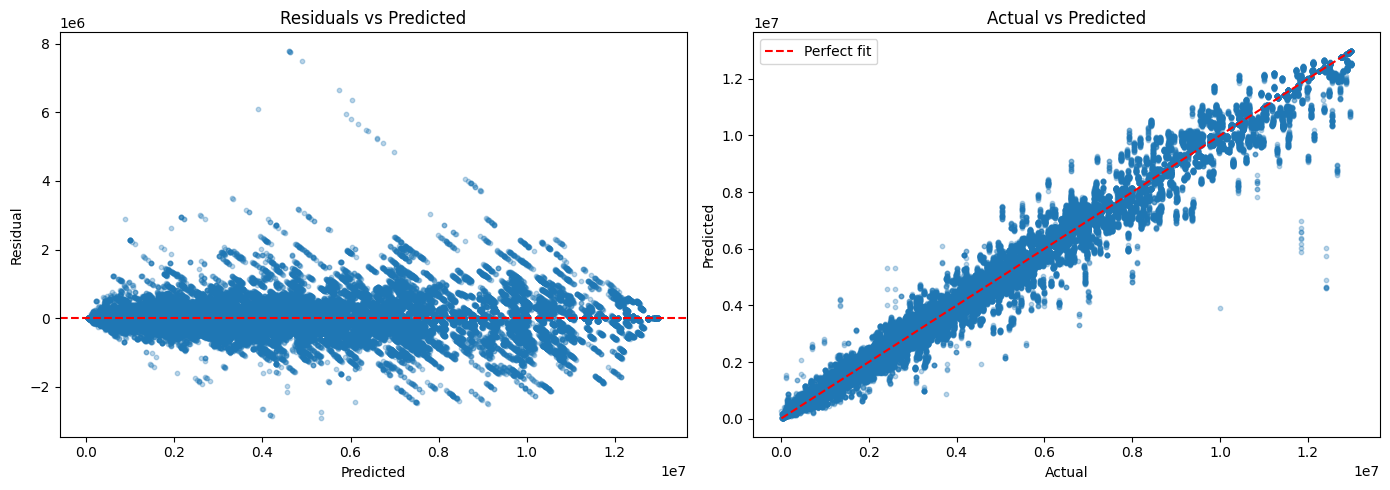

In [33]:
print(best_model)
val_preds = best_model.predict(X_val)
mae  = mean_absolute_error(y_val, val_preds)
rmse = root_mean_squared_error(y_val, val_preds)
print(f"Validation MAE:  {mae:,.2f}")
print(f"Validation RMSE: {rmse:,.2f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals plot
residuals = y_val - val_preds
axes[0].scatter(val_preds, residuals, alpha=0.3, s=10)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residual")
axes[0].set_title("Residuals vs Predicted")

# Actual vs Predicted plot
axes[1].scatter(y_val, val_preds, alpha=0.3, s=10)
min_val = min(y_val.min(), val_preds.min())
max_val = max(y_val.max(), val_preds.max())
axes[1].plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect fit")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].set_title("Actual vs Predicted")
axes[1].legend()

plt.tight_layout()
plt.show()


## 7. Prediction on Test Set

`X_test` was preprocessed using the same fitted encoders and scaler in Section 4. We predict `total_bid` for each pay-item row, then aggregate to one prediction per `row_id` by taking the **mean** across pay items belonging to the same job.


In [31]:
test_preds = best_model.predict(X_test)
df_test["predicted_total_bid"] = test_preds

# Aggregate to one prediction per row_id — mean across pay items
test_submission = (
    df_test.groupby("row_id")["predicted_total_bid"]
    .mean()
    .reset_index()
)
print(f"Generated {len(test_submission)} job-level predictions")


Generated 1447 job-level predictions


## 8. Submission

Format the predictions according to `sample_submission.csv` and save the result to a CSV file ready for upload.

In [ ]:
submission = test_submission.rename(columns={"predicted_total_bid": "total_bid"})

# Align to the exact row order defined by sample_submission.csv
submission = sample_sub[["row_id"]].merge(submission, on="row_id", how="left")

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")
submission.head()


Saved submission.csv
NaN predictions: 0


,row_id,total_bid
0,JOB_000008__CON_000103,3.595402e+05
1,JOB_000030__CON_000061,5.342733e+05
2,JOB_000030__CON_000217,5.342733e+05
3,JOB_000045__CON_000037,2.313646e+06
4,JOB_000045__CON_000122,2.313646e+06
